In [1]:
import sys
import os

sys.path.append(os.path.abspath("RL_course"))

In [2]:
import gymnasium as gym
import rl_dbs.gym_oscillator
import rl_dbs.gym_oscillator.envs
import rl_dbs.oscillator_cpp
env = rl_dbs.gym_oscillator.envs.oscillatorEnv()

In [3]:
from sb3_contrib import TRPO
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt
import numpy as np

2024-12-16 03:59:31.711262: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-16 03:59:32.756428: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/modules/R/R-4.4.1/lib64:/opt/modules/gcc/GCC850/lib64:/opt/modules/gcc/GCC850/lib:/opt/modules/Python/3.11.5/lib:/opt/modules/Python/3.9.14/lib
2024-12-16 03:59:32.756454: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [61]:
from stable_baselines3.common.callbacks import BaseCallback
import numpy as np

class TRPOLoggerCallback(BaseCallback):
    """
    Custom callback to log KL divergence, value loss, policy objective, and episode rewards.
    """
    def __init__(self):
        super().__init__()
        self.kl_losses = []            # KL Divergence Loss
        self.value_losses = []         # Value Loss
        self.policy_objectives = []    # Policy Objective
        self.episode_rewards = []      # Rewards per episode
        self.episode_lengths = []      # Lengths of episodes
        self.timesteps = []            # Timesteps
        self.current_episode_reward = 0
        self.current_episode_length = 0
        self.timestep = 0

    def _on_step(self) -> bool:
        # Log rewards at each step
        reward = self.locals.get("rewards", [0])[0]
        self.current_episode_reward += reward
        self.current_episode_length += 1

        # Log timestep
        self.timesteps.append(self.timestep)
        self.timestep += 1

        # Log KL divergence loss (Stable-Baselines3 uses 'train/' keys)
        if "train/kl_divergence_loss" in self.logger.name_to_value:
            self.kl_losses.append(self.logger.name_to_value["train/kl_divergence_loss"])
        else:
            self.kl_losses.append(0)

        # Log value loss
        if "train/value_loss" in self.logger.name_to_value:
            self.value_losses.append(self.logger.name_to_value["train/value_loss"])
        else:
            self.value_losses.append(0)

        # Log policy objective
        if "train/policy_objective" in self.logger.name_to_value:
            self.policy_objectives.append(self.logger.name_to_value["train/policy_objective"])
        else:
            self.policy_objectives.append(0)

        # Check if the episode is done
        if self.locals.get("dones", [False])[0]:
            # Log rewards and episode lengths
            self.episode_rewards.append(self.current_episode_reward)
            self.episode_lengths.append(self.current_episode_length)
            self.current_episode_reward = 0  # Reset for the next episode
            self.current_episode_length = 0

        return True

    def on_training_end(self):
        """
        Save all collected logs to files after training ends.
        """
        np.save("kl_losses.npy", self.kl_losses)
        np.save("value_losses.npy", self.value_losses)
        np.save("policy_objectives.npy", self.policy_objectives)
        np.save("episode_rewards.npy", self.episode_rewards)
        np.save("episode_lengths.npy", self.episode_lengths)
        np.save("timesteps.npy", self.timesteps)


In [62]:
# Initialize environment
env = rl_dbs.gym_oscillator.envs.oscillatorEnv()
policy_kwargs = dict(net_arch=[64])
model = TRPO(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=0.002,
    batch_size=16,
    gamma=0.99,
    policy_kwargs=policy_kwargs
)

# Train with the callback
callback = TRPOLoggerCallback()
model.learn(total_timesteps=25000, callback=callback)



Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 1707 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
----------------------------------------
| time/                     |          |
|    fps                    | 1293     |
|    iterations             | 2        |
|    time_elapsed           | 3        |
|    total_timesteps        | 4096     |
| train/                    |          |
|    explained_variance     | 0.00647  |
|    is_line_search_success | 1        |
|    kl_divergence_loss     | 0.0077   |
|    learning_rate          | 0.002    |
|    n_updates              | 1        |
|    policy_objective       | 0.0242   |
|    std                    | 0.95     |
|    value_loss             | 533      |
----------------------------------------
---------------------------------------

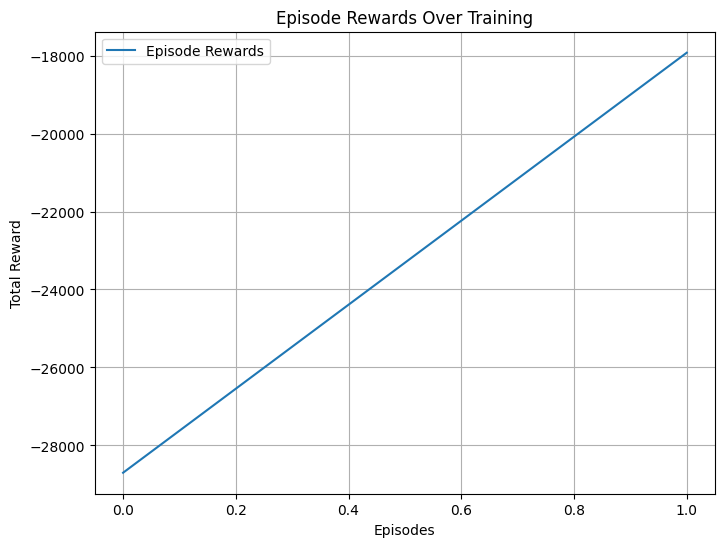

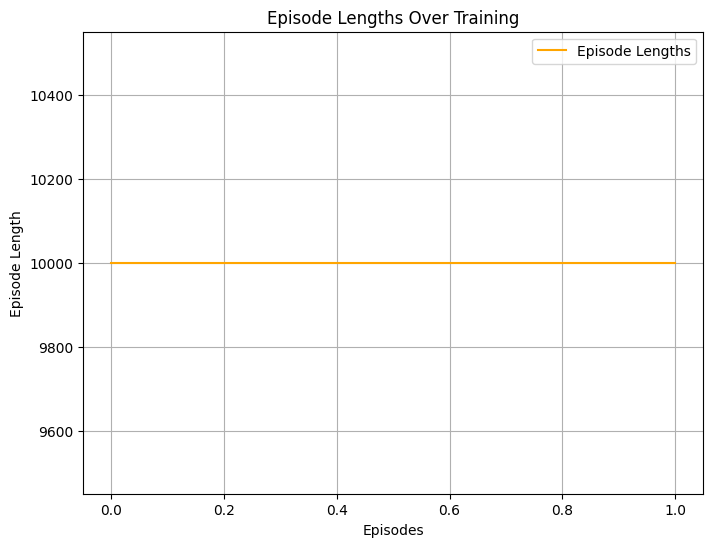

In [63]:
import numpy as np
import matplotlib.pyplot as plt

# Load data
episode_rewards = np.load("episode_rewards.npy")
episode_lengths = np.load("episode_lengths.npy")

# Plot Episode Rewards
plt.figure(figsize=(8, 6))
plt.plot(episode_rewards, label="Episode Rewards")
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Episode Rewards Over Training")
plt.legend()
plt.grid()
plt.show()

# Plot Episode Lengths
plt.figure(figsize=(8, 6))
plt.plot(episode_lengths, label="Episode Lengths", color="orange")
plt.xlabel("Episodes")
plt.ylabel("Episode Length")
plt.title("Episode Lengths Over Training")
plt.legend()
plt.grid()
plt.show()


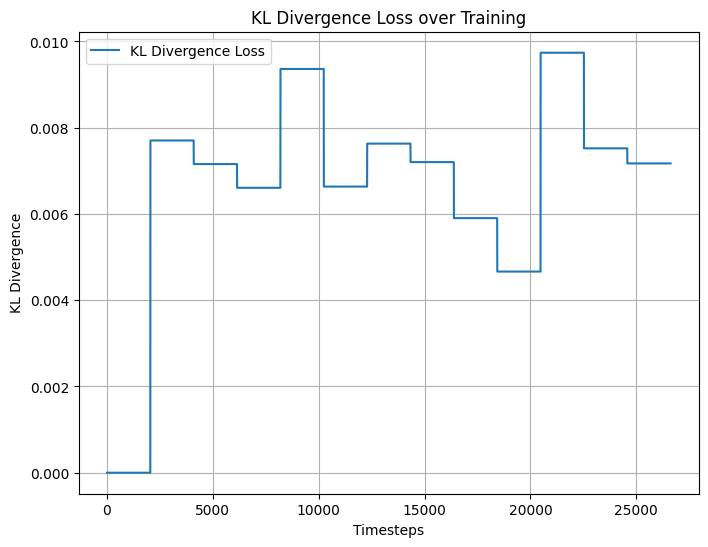

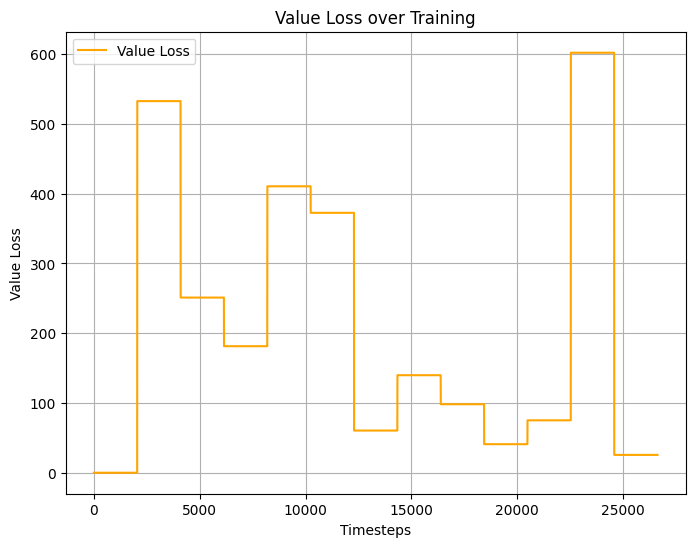

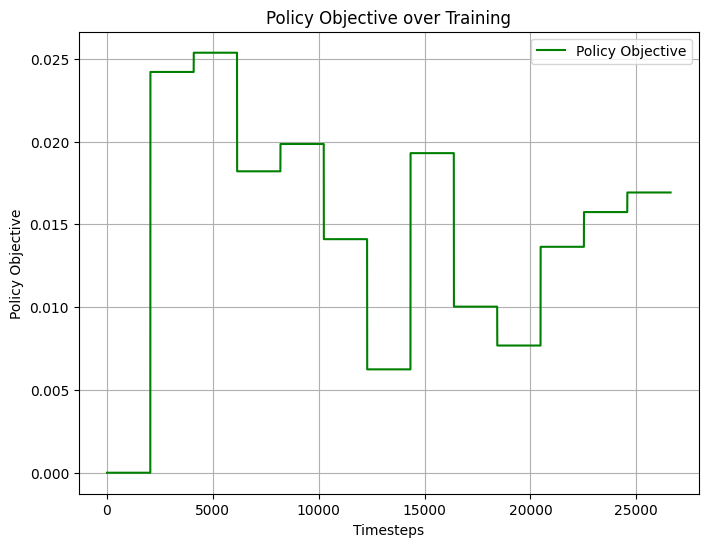

In [64]:
import numpy as np
import matplotlib.pyplot as plt

# Load logged data
kl_losses = np.load("kl_losses.npy")
value_losses = np.load("value_losses.npy")
policy_objectives = np.load("policy_objectives.npy")
timesteps = np.load("timesteps.npy")

# Plot KL Divergence Loss
plt.figure(figsize=(8, 6))
plt.plot(timesteps, kl_losses, label="KL Divergence Loss")
plt.xlabel("Timesteps")
plt.ylabel("KL Divergence")
plt.title("KL Divergence Loss over Training")
plt.legend()
plt.grid()
plt.show()

# Plot Value Loss
plt.figure(figsize=(8, 6))
plt.plot(timesteps, value_losses, label="Value Loss", color="orange")
plt.xlabel("Timesteps")
plt.ylabel("Value Loss")
plt.title("Value Loss over Training")
plt.legend()
plt.grid()
plt.show()

# Plot Policy Objective
plt.figure(figsize=(8, 6))
plt.plot(timesteps, policy_objectives, label="Policy Objective", color="green")
plt.xlabel("Timesteps")
plt.ylabel("Policy Objective")
plt.title("Policy Objective over Training")
plt.legend()
plt.grid()
plt.show()


In [72]:
# Save the logged data
# np.save("./DBS/logs/train_rewards.npy", callback.rewards)
# np.save("./DBS/logs/train_actions.npy", callback.actions)
# np.save("./DBS/logs/train_states_x.npy", callback.states_x)
# np.save("./DBS/logs/train_timesteps.npy", callback.timesteps)
# np.save("./DBS/logs/train_losses.npy", callback.losses)  # Save losses


In [73]:
model.save("./DBS/models/trpo_rl_dbs_1")

In [76]:
# import gymnasium as gym
# import rl_dbs.gym_oscillator
# import rl_dbs.gym_oscillator.envs
# from sb3_contrib import TRPO
# import matplotlib.pyplot as plt
# import numpy as np

# Initialize environment with 1000 oscillators
env = rl_dbs.gym_oscillator.envs.oscillatorEnv(nosc=1000, ep_length=5000, epsilon=0.03)

# Load the trained model
# model = TRPO.load("trpo_model")

# Test the agent and log data
states = []
actions = []
timesteps = []
x_val_history = []
timestep = 0

# Reset environment
obs, _ = env.reset()
done = False

while not done:
    # Predict action from the trained model
    action, _ = model.predict(obs)  # deterministic=True for testing
    
    # Take a step in the environment
    obs, reward, _, done, _ = env.step(action)
    
    # Log data
    x_val_history.append(env.x_val)  # Mean field X value
    actions.append(action[0])        # Action applied
    states.append(obs)               # Full state observed
    timesteps.append(timestep)       # Record timestep
    timestep += 1

# Save testing logs
np.save("./DBS/logs/reg_test_x_val.npy", x_val_history)
np.save("./DBS/logs/reg_test_actions.npy", actions)
np.save("./DBS/logs/reg_test_timesteps.npy", timesteps)

print("Regual testing complete. Logs saved successfully.")


Regual testing complete. Logs saved successfully.


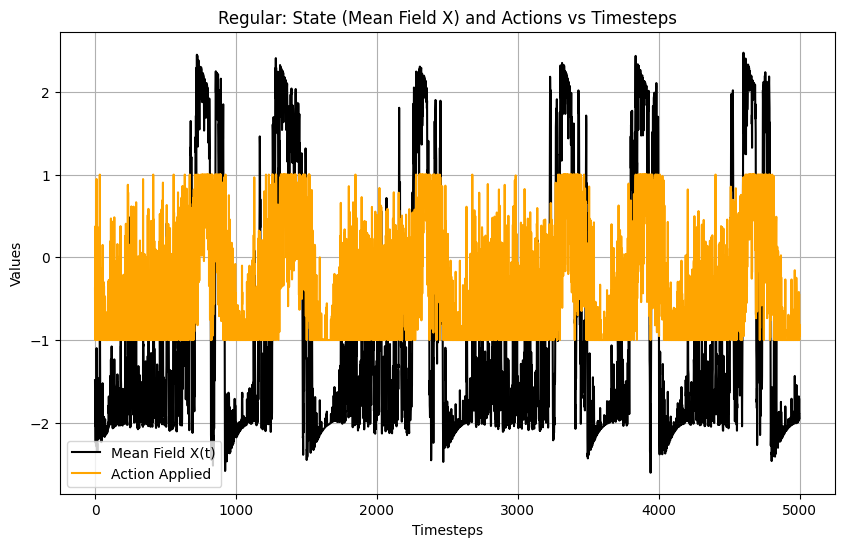

In [77]:
# Load saved logs
x_val_history = np.load("./DBS/logs/reg_test_x_val.npy")
actions = np.load("./DBS/logs/reg_test_actions.npy")
timesteps = np.load("./DBS/logs/reg_test_timesteps.npy")

# Plot mean field X(t) and actions
plt.figure(figsize=(10, 6))

# Plot X(t)
plt.plot(timesteps, x_val_history, label="Mean Field X(t)", color="black")

# Plot actions
plt.plot(timesteps, actions, label="Action Applied", color="orange")

plt.xlabel("Timesteps")
plt.ylabel("Values")
plt.title("Regular: State (Mean Field X) and Actions vs Timesteps")
plt.legend()
plt.grid()
plt.show()


In [68]:
import gymnasium as gym
import rl_dbs.gym_oscillator
import rl_dbs.gym_oscillator.envs
from sb3_contrib import TRPO
import matplotlib.pyplot as plt
import numpy as np

# Initialize environment with 1000 oscillators
env = rl_dbs.gym_oscillator.envs.oscillatorEnv(nosc=1000, ep_length=5000, epsilon=0.02)

# Load the trained model
# model = TRPO.load("trpo_model")

# Test the agent and log data
states = []
actions = []
timesteps = []
x_val_history = []
timestep = 0

# Reset environment
obs, _ = env.reset()
done = False

while not done:
    # Predict action from the trained model
    action, _ = model.predict(obs)  # deterministic=True for testing
    
    # Take a step in the environment
    obs, reward, _, done, _ = env.step(action)
    
    # Log data
    x_val_history.append(env.x_val)  # Mean field X value
    actions.append(action[0])        # Action applied
    states.append(obs)               # Full state observed
    timesteps.append(timestep)       # Record timestep
    timestep += 1

# Save testing logs
np.save("./DBS/logs/chao_test_x_val.npy", x_val_history)
np.save("./DBS/logs/chao_test_actions.npy", actions)
np.save("./DBS/logs/chao_test_timesteps.npy", timesteps)

print("Chaotic testing complete. Logs saved successfully.")


Chaotic testing complete. Logs saved successfully.


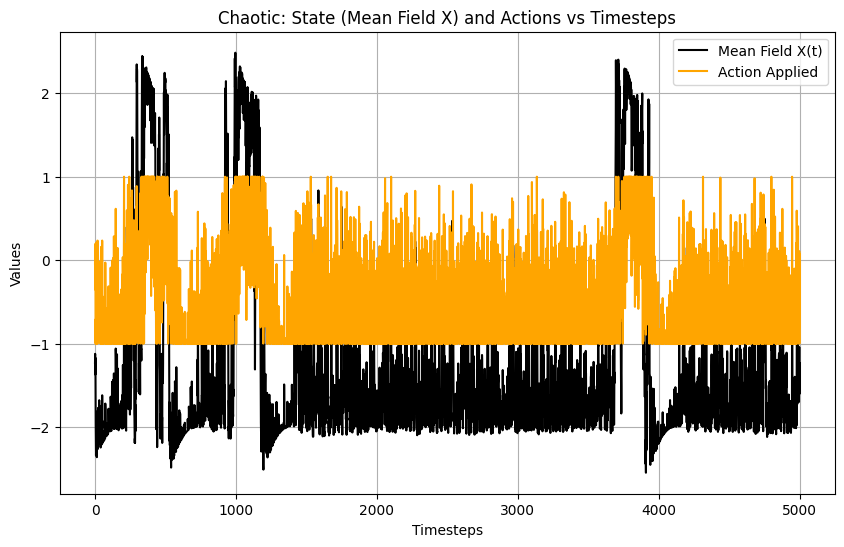

In [70]:
# Load saved logs
x_val_history = np.load("./DBS/logs/chao_test_x_val.npy")
actions = np.load("./DBS/logs/chao_test_actions.npy")
timesteps = np.load("./DBS/logs/chao_test_timesteps.npy")

# Plot mean field X(t) and actions
plt.figure(figsize=(10, 6))

# Plot X(t)
plt.plot(timesteps, x_val_history, label="Mean Field X(t)", color="black")

# Plot actions
plt.plot(timesteps, actions, label="Action Applied", color="orange")

plt.xlabel("Timesteps")
plt.ylabel("Values")
plt.title("Chaotic: State (Mean Field X) and Actions vs Timesteps")
plt.legend()
plt.grid()
plt.show()


Starting Initial Non-Suppression Phase...
Starting Suppression Phase...
Starting Final Relaxation Phase...


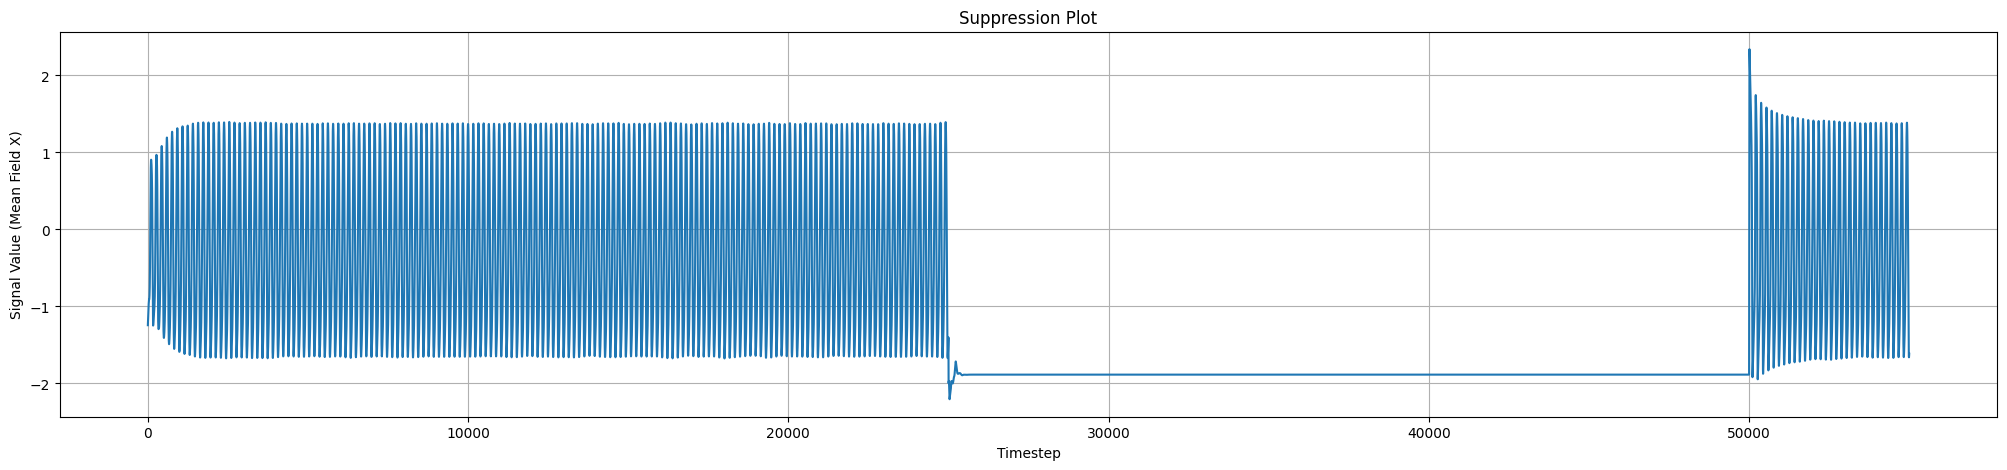

Model Score:
30492413.857820883
5521.993648839238
-0.2640392859327361


In [71]:
import gymnasium as gym
import rl_dbs.gym_oscillator
import rl_dbs.gym_oscillator.envs
from sb3_contrib import TRPO
import matplotlib.pyplot as plt
import numpy as np

# Initialize environment with 1000 oscillators
env = rl_dbs.gym_oscillator.envs.oscillatorEnv(nosc=1000, ep_length=5000, epsilon=0.03)

# Load the trained model
# model = TRPO.load("trpo_model")

# Initialize storage for logging results
rews_ = []       # Rewards
obs_ = []        # Observed states
acs_ = []        # Actions
states_x = []    # Mean field X
states_y = []    # Mean field Y

# Initial non-suppression phase (no actions)
print("Starting Initial Non-Suppression Phase...")
obs, _ = env.reset()
for i in range(25000):
    obs, rewards, done, _, _ = env.step([0])  # No actions applied
    states_x.append(env.x_val)  # Mean field X
    states_y.append(env.y_val)  # Mean field Y
    obs_.append(obs[0])
    acs_.append(0)
    rews_.append(rewards)

# Suppression phase (agent applies actions)
print("Starting Suppression Phase...")
for i in range(25000):
    action, _ = model.predict(obs, deterministic=True)
    obs, rewards, done, _, _ = env.step(action)
    states_x.append(env.x_val)
    states_y.append(env.y_val)
    obs_.append(obs[0])
    acs_.append(action[0] if isinstance(action, (list, np.ndarray)) else action)
    rews_.append(rewards)

# Final relaxation phase (no actions)
print("Starting Final Relaxation Phase...")
for i in range(5000):
    obs, rewards, done, _, _ = env.step([0])  # No actions applied
    states_x.append(env.x_val)
    states_y.append(env.y_val)
    obs_.append(obs[0])
    acs_.append(0)
    rews_.append(rewards)

# Save logs
np.save("states_x.npy", states_x)
np.save("actions.npy", acs_)
np.save("rewards.npy", rews_)

# Plot suppression plot
plt.figure(figsize=(25, 5))
plt.title("Suppression Plot")
plt.xlabel("Timestep")
plt.ylabel("Signal Value (Mean Field X)")
plt.plot(states_x)
plt.grid()
plt.show()

# Model Score Calculation
print("Model Score:")
print(np.std(states_x[5000:25000]) / np.std(states_x[30000:45000]))  # Suppression ratio
s = np.std(states_x[5000:25000]) / np.std(states_x[30000:45000])
print(np.sqrt(s))

print(np.mean(states_x[5000:15000]))  # Mean value during suppression phase


Starting Initial Non-Suppression Phase...
Starting Suppression Phase...
Starting Final Relaxation Phase...


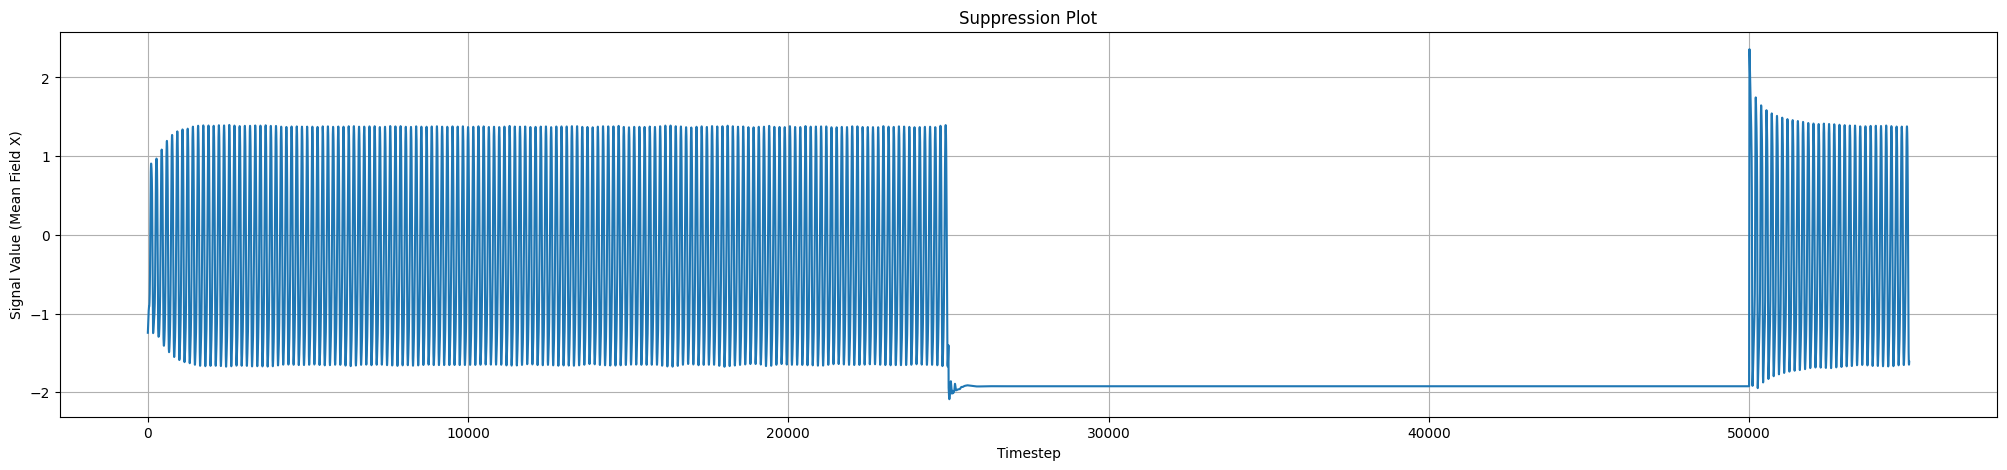

Model Score:
2489633367582914.5
49896225.98536801
-0.2640392859327361


In [28]:
import gymnasium as gym
import rl_dbs.gym_oscillator
import rl_dbs.gym_oscillator.envs
from sb3_contrib import TRPO
import matplotlib.pyplot as plt
import numpy as np

# Initialize environment with 1000 oscillators
env = rl_dbs.gym_oscillator.envs.oscillatorEnv(nosc=1000, ep_length=5000, epsilon=0.02)

# Load the trained model
# model = TRPO.load("trpo_model")

# Initialize storage for logging results
rews_ = []       # Rewards
obs_ = []        # Observed states
acs_ = []        # Actions
states_x = []    # Mean field X
states_y = []    # Mean field Y

# Initial non-suppression phase (no actions)
print("Starting Initial Non-Suppression Phase...")
obs, _ = env.reset()
for i in range(25000):
    obs, rewards, done, _, _ = env.step([0])  # No actions applied
    states_x.append(env.x_val)  # Mean field X
    states_y.append(env.y_val)  # Mean field Y
    obs_.append(obs[0])
    acs_.append(0)
    rews_.append(rewards)

# Suppression phase (agent applies actions)
print("Starting Suppression Phase...")
for i in range(25000):
    action, _ = model.predict(obs, deterministic=True)
    obs, rewards, done, _, _ = env.step(action)
    states_x.append(env.x_val)
    states_y.append(env.y_val)
    obs_.append(obs[0])
    acs_.append(action[0] if isinstance(action, (list, np.ndarray)) else action)
    rews_.append(rewards)

# Final relaxation phase (no actions)
print("Starting Final Relaxation Phase...")
for i in range(5000):
    obs, rewards, done, _, _ = env.step([0])  # No actions applied
    states_x.append(env.x_val)
    states_y.append(env.y_val)
    obs_.append(obs[0])
    acs_.append(0)
    rews_.append(rewards)

# Save logs
np.save("states_x.npy", states_x)
np.save("actions.npy", acs_)
np.save("rewards.npy", rews_)

# Plot suppression plot
plt.figure(figsize=(25, 5))
plt.title("Suppression Plot")
plt.xlabel("Timestep")
plt.ylabel("Signal Value (Mean Field X)")
plt.plot(states_x)
plt.grid()
plt.show()

# Model Score Calculation
print("Model Score:")
print(np.std(states_x[5000:25000]) / np.std(states_x[30000:45000]))  # Suppression ratio
s = np.std(states_x[5000:25000]) / np.std(states_x[30000:45000])
print(np.sqrt(s))

print(np.mean(states_x[5000:15000]))  # Mean value during suppression phase
